In [1]:
import gym
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from collections import deque
from copy import deepcopy

device = "cuda" if torch.cuda.is_available() else "cpu"

# MountainCarContinuous-v0 

Во втором задании нужно решить MountainCarContinuous-v0, где в отличии от обычного MountainCar используются вещественные действия (то есть одно) - отрицательное значение заставляет машинку ехать назад, а положительное вперед. Интересна и функция реварда - агенту дается 100 очков за заезд на горку за вычетом суммы квадратов всех действий. Из этого следует, что если агент не заедет на гору достаточно быстро, он выучится стоять на месте и получать 0.0 награды.

Решением считается 90 награды в среднем за 100 запусков.

## DDPG & TD3

Среды с вещественными действиями можно решать несколькими способами. Самым простым вариантом будет дискретизировать пространство действий и использовать обычный DQN как в прошлом задании. Тем не менее, есть алгоритмы специально созданные для работы с подобными средами, например DDPG. DDPG в идее очень похоже на DQN и является просто расширением на вещественные действия (actions), где мы используем отдельную сеть Actor, которая учится находить действие, максимизирующее Q функцию. 

У DDPG есть известные недостатки, которые попытались исправить в также очень известном алгоритме Twin Delayed DDPG или TD3. Основное отличие - использование двух сетей для оценок Q функции, чтобы поправить overestimation bias, а слово Delayed говорит о том, что Actor обновляется только раз в $N$ обновлений Critic'a. 

Алгоритм для меня новый (совсем) и я, признаюсь, кажется не заставил его работать до конца. Он легко решает задачу, но только при некоторых гиперпараметрах и даже если решает, то после получения необходимого реварда быстро расходится и скатывается в -99 реварда вместо нужных 90. В целом я не придумал как его стабилизровать, поэтому для задания просто останавливаю обучение при достижении среднего реварда 90 за 100 запусков.

**UPD**: в последний момент на меня снизошло озарение и я поставил модели гораздо большие значения шума, который добавляется в действия, чтобы бустить эксплорейшн. После этого обучения стало гораздо более стабильным, а в конце вообще выходит на плато и остается на нем! (чаще да, чем нет)

Интересно, что в данном задании policy delay оказалось даже вредным, при любом значении выше 1 я не дождался положительной награды. Возможно, потому что сеть так банально дольше учится (у меня была гипотеза, что это сделает обучение более стабильным). 

In [2]:
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)
        
    def add(self, transition):
        self.buffer.append(transition)
        
    def sample(self, size):
        batch = random.sample(self.buffer, size)
        return list(zip(*batch))

In [3]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        
        self.actor = nn.Sequential(
            nn.Linear(state_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, action_size)
        )        
    
    def forward(self, state):
        out = self.actor(state)
        return torch.tanh(out)

class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(state_size + action_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        ) 
        
    def forward(self, state, action):
        state_action = torch.cat([state, action], dim=1)
        return self.critic(state_action).view(-1)

In [4]:
class TD3:
    def __init__(self, state_size, action_size, gamma=0.99, tau=0.005, 
                       actor_lr=1e-3, critic_lr=1e-3, target_noise=0.1):
        self.actor = Actor(state_size, action_size).to(device)
        self.target_actor = deepcopy(self.actor).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        
        self.critic1 = Critic(state_size, action_size).to(device)
        self.target_critic1 = deepcopy(self.critic1).to(device)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=critic_lr)
        
        self.critic2 = Critic(state_size, action_size).to(device)
        self.target_critic2 = deepcopy(self.critic2).to(device)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=critic_lr)
        
        self.gamma = gamma
        self.tau = tau
        self.target_noise = target_noise

    def act(self, state):
        with torch.no_grad():
            state = torch.tensor(state, device=device, dtype=torch.float32)
            action = self.actor(state).cpu().numpy()
        
        return action
    
    def soft_update(self, target_net, source_net):
        for target_param, source_param, in zip(target_net.parameters(), source_net.parameters()):
            update = (1 - self.tau) * target_param.data + self.tau * source_param.data
            target_param.data.copy_(update)

    def actor_loss(self, state):
        loss = -self.critic1(state, self.actor(state)).mean()
        return loss
    
    def critic_loss(self, state, action, reward, next_state, done):
        with torch.no_grad():
            next_action = self.target_actor(next_state)
            next_action = torch.clip(next_action + self.target_noise * torch.randn_like(next_action), -1.0, 1.0)
            
            Q_next = torch.minimum(
                self.target_critic1(next_state, next_action), 
                self.target_critic2(next_state, next_action)
            )
            Q_target = reward + self.gamma * (1 - done) * Q_next
        
        Q1 = self.critic1(state, action)
        Q2 = self.critic2(state, action)
        
        critic1_loss = F.mse_loss(Q1, Q_target)
        critic2_loss = F.mse_loss(Q2, Q_target)
        
        return critic1_loss + critic2_loss
        
    def update(self, batch, update_actor=False):
        state, action, reward, new_state, done = batch
        
        state = torch.tensor(state, device=device, dtype=torch.float32)
        action = torch.tensor(action, device=device, dtype=torch.long)
        reward = torch.tensor(reward, device=device, dtype=torch.float32)
        next_state = torch.tensor(new_state, device=device, dtype=torch.float32)
        done = torch.tensor(done, device=device, dtype=torch.float32)
        
        critic_losses = self.critic_loss(state, action, reward, next_state, done)
        
        # Critic1 & Critic2 update
        self.critic1_optimizer.zero_grad()
        self.critic2_optimizer.zero_grad()
        critic_losses.backward()
        self.critic1_optimizer.step()
        self.critic2_optimizer.step()
        
        if update_actor:
            # Actor update
            actor_loss = self.actor_loss(state)
            
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            
            #  Target networks soft update
            with torch.no_grad():
                self.soft_update(self.target_actor, self.actor)
                self.soft_update(self.target_critic1, self.critic1)
                self.soft_update(self.target_critic2, self.critic2)

In [5]:
def rollout(env, model):
    total_reward = 0.0
    done, state = False, env.reset()
    
    while not done:
        action = model.act(state)
        
        new_state, reward, done, _ = env.step(action)
        total_reward += reward

        state = new_state

    return total_reward

def evaluate_model(model, episodes=10):
    env = gym.make("MountainCarContinuous-v0")
    env.seed(22) 

    rewards = []

    for _ in range(episodes):
        rewards.append(rollout(env, model))

    return np.mean(rewards), np.std(rewards)

In [6]:
def train(model, timesteps=500_000, start_train=10_000, buffer_size=100_000, batch_size=512, test_every=5000,
          policy_delay=2, max_action_noise=0.1, min_action_noise=0.1, shaping_scale=300):

    env = gym.make("MountainCarContinuous-v0")
    
    env.seed(22)
    random.seed(22)
    np.random.seed(22)
    torch.manual_seed(22)
  
    reward_means, reward_std = [], []
    
    buffer = ReplayBuffer(size=buffer_size)
    done, state = False, env.reset()

    for step in range(timesteps):
        if done:
            done, state = False, env.reset()

        action_noise = max_action_noise - (max_action_noise - min_action_noise) * step / timesteps

        action = model.act(state)
        action = np.clip(action + action_noise * np.random.randn(len(action)), -1.0, 1.0)
            
        new_state, reward, done, _ = env.step(action)

        reward = reward + shaping_scale * (model.gamma * abs(new_state[1]) - abs(state[1])) 
        buffer.add((state, action, reward, new_state, int(new_state[0] >= 0.5)))
        
        state = new_state
        
        if step >= start_train:
            update_actor = True if step % policy_delay == 0 else False
            model.update(buffer.sample(size=batch_size), update_actor=update_actor)
            
            if step % test_every == 0 or step == timesteps - 1:
                mean, std = evaluate_model(model, episodes=10)

                reward_means.append(mean)
                reward_std.append(std)
                
                print(f"Step: {step}, Mean reward: {mean:.2f}, std: {std:.2f}, action_noise: {action_noise:.4f}")

    return np.array(reward_means), np.array(reward_std)

# Обучение Агента

In [9]:
td3 = TD3(2, 1, tau=0.001, gamma=0.99, actor_lr=0.001, critic_lr=0.001, target_noise=0.0)

means, stds = train(td3, timesteps=200_000, start_train=1000, batch_size=256, max_action_noise=2.0, min_action_noise=0.0, 
                    policy_delay=1, buffer_size=50_000, test_every=1000) 

Step: 1000, Mean reward: -3.30, std: 0.01, action_noise: 1.9900
Step: 2000, Mean reward: -28.83, std: 1.97, action_noise: 1.9800
Step: 3000, Mean reward: -35.54, std: 4.17, action_noise: 1.9700
Step: 4000, Mean reward: -31.79, std: 7.34, action_noise: 1.9600
Step: 5000, Mean reward: -39.49, std: 6.37, action_noise: 1.9500
Step: 6000, Mean reward: -43.77, std: 4.61, action_noise: 1.9400
Step: 7000, Mean reward: -37.44, std: 3.51, action_noise: 1.9300
Step: 8000, Mean reward: -21.07, std: 0.47, action_noise: 1.9200
Step: 9000, Mean reward: -20.58, std: 0.62, action_noise: 1.9100
Step: 10000, Mean reward: -20.75, std: 0.83, action_noise: 1.9000
Step: 11000, Mean reward: -19.89, std: 1.03, action_noise: 1.8900
Step: 12000, Mean reward: -20.91, std: 1.36, action_noise: 1.8800
Step: 13000, Mean reward: -19.22, std: 1.46, action_noise: 1.8700
Step: 14000, Mean reward: -20.08, std: 1.47, action_noise: 1.8600
Step: 15000, Mean reward: -21.73, std: 1.62, action_noise: 1.8500
Step: 16000, Mean re

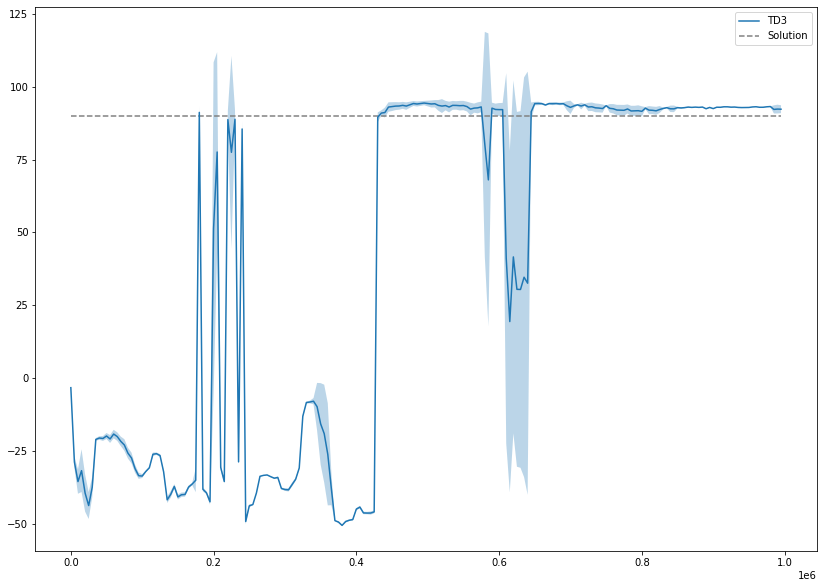

In [10]:
x = np.arange(len(means)) * 5000

plt.figure(figsize=(14, 10))
plt.plot(x, means, label="TD3")
plt.fill_between(x, means - stds, means + stds, alpha=0.3)
plt.hlines(90, 0, np.max(x), label="Solution", colors="gray", linestyles="dashed")
plt.legend();